This task involves comparing the consensus sequence produced by an analysis of real COVID19 samples and the first official version of COVID19 genome.


Introduction:

You are given a file in [FASTA format](https://en.wikipedia.org/wiki/FASTA_format) with data following given conventions:

Header_sequence:  A row with a string starting with a symbol ">" which provides meta information about the content of sequence on the next row
Genomic sequence: A row with a string containing capital characters "NAGCT" in any order describing a genomic sequence. The genomic sequence could belong to a protein, transcript, chromosome or entire genome of an organism.

Example:

\>Header_1\
ATCCAGCT\
\>Header_2\
GGGCAACT\
\>Header_3\
ATGGATCT\
\>Header_4\
AAGCAACC\
\>Header_5\
TTGGAACT\
\>Header_6\
ATGCCATT\
\>Header_7\
ATGGCACT

Create the following figure, or similar representation:

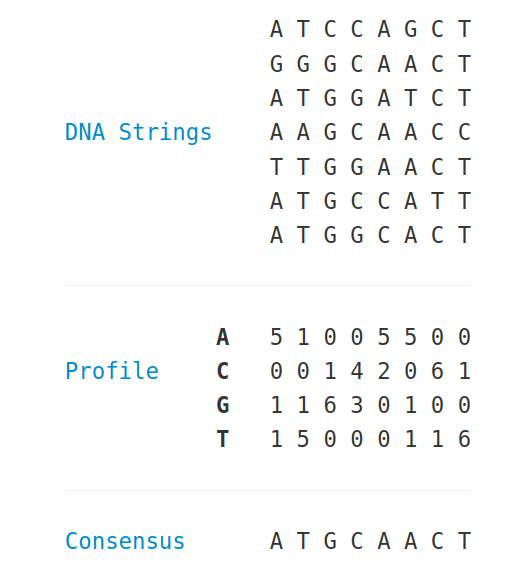

In [64]:
import operator
import string

import numpy
import numpy as np
from IPython.display import Image

Image(filename='output.png')

For the real task, you are provided following files:

In [65]:
path_original_strain = "GCF_009858895.2_ASM985889v3_genomic.fna"  # First original reference genome of SARS-COV-2 virus
path_test_data1 = "consensus1.fasta"  # a FASTA file containing multiple genomes from SARS-COV-2 sequencing experiments
path_test_data2 = "consensus2.fasta"  # a FASTA file containing multiple genomes from SARS-COV-2 sequencing experiments

Examine contents of the files.

Using the original reference genome as pivot, create a profile (as shown above) and calculate a consensus sequence for consensus1 and consensus2 files. You will find that unlike the length of sequences in test data, the real sequences can have varying length among each other and compared to the reference genome. You are free to correct for that any way you see fit, including any inspiration a google search can provide!

Compare consensus sequences from consensus1 and consensus2 with original SARS-COV-2 genome strain and calculate the number of mismatches (genomic position) from the sequence of the original genome.

Both consensus files were generated by routine SARS-COV-2 sequencing analysis performed at Clinical Genomics, however the files were created 8 months apart. Given this information, are there any observations or conclusions that can be made about the data?

In [66]:
def get_original_seq(path):
    with open(path_original_strain) as infile:
        content = infile.read()
        return content[content.index("\n"):].replace("\n", "").upper()

In [67]:
def sqnc_eql(sqnc1: str, sqnc2: str):
    if len(sqnc1) != len(sqnc2):
        return False

    for j in range(len(sqnc1)):
        if sqnc2[j] != 'N' and sqnc2[j] != sqnc1[j]:
            return False

    return True

In [68]:
def read_line(path):
    with open(path_test_data2) as infile2:
        for line in infile2.readlines():
            if not line.startswith('>') and not line == "\n":
                yield line.upper()

In [69]:
o1 = "CTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTT"
s1 = "CTGGTGGCCATAGTTACGGCGCCGATCTAGACTTAGGCGACGAGCTTGGCACTGAT"
s2 = "CTGGTGGGCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTT"
s3 = "NNCTGGTGGGCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTT"

In [70]:

block = 4
res1 = ""
res2 = ""
res3 = ""


def align(block_size, o_1, s_1):
    res = ""
    if block_size == 0:
        return

    ii = i = 0
    while i < len(o_1):
        remaining = len(o_1) - i
        if remaining == 0:
            break

        if remaining < block_size:
            block_size = remaining

        j = 0
        while j < remaining:
            o1_start = i + j
            o1_end = o1_start + block_size
            o1_val = o_1[o1_start:o1_end]
            s_start = ii
            s = s_1[s_start: s_start + block_size]
            eql = sqnc_eql(o1_val, s)
            if eql:
                res += s[:block_size]
                i += block_size + j
                ii += block_size
                break
            else:
                ii += 1
                j += 1
                remaining -= 1
                if len(s) > 0 and len(res) == 0 and s[0] == 'N':
                    break

                l = 0
                if len(s) > 0:
                    res += s[0]
                    l += 1
                s = s_1[s_start + l: s_start + l + block_size]
                found = False

                for k in range(s_start + l, s_start + l + remaining - j):
                    new_o1_val = o_1[k:k + block_size]
                    if sqnc_eql(new_o1_val, s):
                        res += 'N' * (k - (s_start + l)) + new_o1_val
                        i = k + block_size
                        ii += block_size
                        found = True
                        break

                if found:
                    break

    return res


assert align(block, o1, s1) == "CTGGTGGCCATAGTTACGGCGCCGATCTANNNNNNNNNGACTTAGGCGACGAGCTT"
assert align(block, o1, s2) == "CTGGTGGGCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTT"
assert align(block, o1, s3) == "CTGGTGGGCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTT"

print("The test have passed! Yahoo!")


The test have passed! Yahoo!


In [71]:
def get_consensus(path, original_len):
    matrix = np.empty(shape=[0, 0])
    for seq in read_line(path):
        aligned_seq = align(block, original, seq)[:original_len]
        matrix = numpy.append(matrix, list(aligned_seq))

    transposed = matrix.transpose()

    consensus = ""
    for r in transposed:
        line_profile = {"A": 0, "G": 0, "C": 0, "T": 0, "N": 0}
        for g in r:
            if g not in line_profile.keys():
                g = 'N'
            line_profile[g] += 1

        max_g = max(line_profile.items(), key=operator.itemgetter(1))[0]
        consensus += max_g
    return consensus

In [72]:
def calc_diff_with_n(seq1, seq2):
    i = 0
    diff = 0
    while i < len(seq1):
        if seq1[i] != seq2[i]:
            diff += 1
        i += 1

    return diff

In [73]:
def calc_diff_without_n(seq1, seq2):
    i = 0
    diff = 0
    while i < len(seq1):
        if seq2[i] != 'N' and seq1[i] != 'N' and seq1[i] != seq2[i]:
            diff += 1
        i += 1

    return diff

In [74]:
original = get_original_seq(path_original_strain)
o_len = len(original)

consensus1 = get_consensus(path_test_data1, o_len)
print("consensus 1 diff accounting for N: {}".format(calc_diff_with_n(original, consensus1)))
print("consensus 1 diff discarding N: {}".format(calc_diff_without_n(original, consensus1)))


consensus2 = get_consensus(path_test_data2, o_len)
print("consensus 2 diff accounting for N: {}".format(calc_diff_with_n(original, consensus2)))
print("consensus 2 diff discarding N: {}".format(calc_diff_without_n(original, consensus2)))

consensus 1 diff accounting for N: 23293
consensus 1 diff discarding N: 17537
consensus 2 diff accounting for N: 23293
consensus 2 diff discarding N: 17537
